In [8]:
import json
import pandas
import numpy
import os
import string
import eval

# pathogen prepare

In [3]:
with open("../PubMed_Search/search_results/search_results_hanimals.txt","r") as f:
    content = f.read()
    spec_papers_dic = json.loads(content)

In [4]:
# 预测样本格式转换
papers_l = {}
for spec_type in spec_papers_dic:

    for spec,spec_papers in spec_papers_dic[spec_type].items():
        
        for paper_id, paper in spec_papers.items():
            
            papers_l['%s:%s' % (paper_id, spec)] = paper


In [24]:
test_qa = []
test_set = {"data": [{'paragraphs': [], 'title':"LungB"}], "version": "LungB"}

for paper_id,paper in papers_l.items():
    
    qa = {'qas': [{
        'id': paper_id,
        'question': 'Can %s cause Pneumonia?' % paper_id.split(":")[-1]}],
        'context': paper["texts"]["Ab"]+" "+" ".join(sum(paper["Meshhead"],[])) } # 添加mesh词汇
        
    if len(paper["texts"]["Ab"]) > 0:
        test_qa.append(qa)

In [25]:
with open("input/input_pat/test_qa.txt", "w") as output:
    a = json.dumps(test_qa)
    output.write(a)

# 测试

In [1]:
import pandas as pd
train_data = pd.read_csv("output/eval_prediction.csv", index_col=0)
train_data = train_data[~train_data.index.duplicated(keep='first')]
standard_0 = pd.read_csv("output/eval_standards.csv", index_col=0)
standard_0 = standard_0[~standard_0.index.duplicated(keep='first')]

In [2]:
pneumonia = {"bronchitis","bronchopneumonia","pneumonia","pneumonitis","pneumonic","pleuropneumonia","pleural"}
LungRelated = {"bronchus","bronchial","tracheobronchial","bronchiolar","bronchopulmonary",
               "bronchoalveolar","bronchoscopy",
               "lung","pulmonary","pneumonic","bronchopulmonary","respiratory","respiration"}
infection = {"infection","infections","abscess","pathology","etiology","diseases",
             "bacteremia","sepsis","septic","pathogenicity","legionellosis","empyema","necrosis"}

In [3]:
train_extend = {}
for i in train_data.index:
    if i.lower() in papers_l:
        train_extend[i] = papers_l[i.lower()]
    else:
        print(train_data.loc[i])

NameError: name 'papers_l' is not defined

In [4]:
pats = {}
for paper_id, paper in train_extend.items():
    spec = paper_id.split(":")[1].lower()
    text = paper["texts"]["Ab"] +" "+" ".join(sum(paper["Meshhead"],[])) # 添加mesh词汇
    text = text.translate(str.maketrans(string.punctuation, " "*32,)).replace("  ", " ")
    text = text.lower()
    words = set(text.split(" "))
    if len(words & pneumonia) > 0:
        if "colonization" not in words:
            if "%s / isolation & purification" % spec not in " / ".join(sum(paper["Meshhead"],[])).lower():
                pats[paper_id] = paper
    else:
        if len(words & LungRelated) > 0:
            if len(words & infection) > 0:
                if "colonization" not in words:
                    if "%s / isolation & purification" % spec not in " / ".join(sum(paper["Meshhead"],[])).lower():
                        pats[paper_id] = paper


In [5]:
cut = 0.5
train_data.loc[train_data["rate"]>=cut, "prediction"] = "yes"
train_data.loc[train_data["rate"]<cut, "prediction"] = "no"

for i in range(train_data.shape[0]):
    if train_data.index[i] not in pats:
        if train_data["prediction"][i] == 'yes':
            train_data["prediction"][i] = 'no'

/tmp/ipykernel_2623940/663317541.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["prediction"][i] = 'no'


In [6]:
import numpy as np

prediction_0 = train_data
prediction_0.loc[prediction_0["prediction"]=="yes", "prediction"] = 1
prediction_0.loc[prediction_0["prediction"]=="no", "prediction"] = 0
prediction_0 = prediction_0.astype(np.int64)
fig_path = ("output")

/home/data/t070224/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


结果: 0.7553628480146052 0.0 0.0 0.0


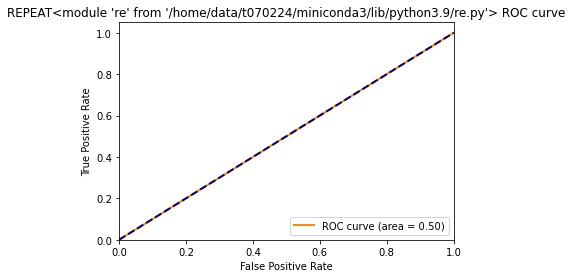

(0.7553628480146052, 0.0, 0.0, 0.0)

In [9]:
eval.evaluate(standard_0, prediction_0, fig_path)